In [1]:
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd

from paper_changes import *
from collections import defaultdict
from tqdm import tqdm
from scipy.stats import zscore
from glob import glob

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [20]:
def load_data(fn, field='relative', zscore=True):
    #infile = '/userdata/pdaly/supereeg/results/samp100_2h_54pid_pos-1.18.power.pkl'
    data = pickle.load(open(fn, 'rb'))
    labels = pd.read_csv('/home/kscangos/Sandbox/full_patient_list_pd_feb.csv', index_col=0)
    labels['pid'] = labels.index.map(lambda pid: pid[2:])
    df = data[field]
    df = df.reset_index().merge(labels[['pid', 'dep']], left_on='index',
                           right_on='pid').set_index('index').drop('pid', axis=1)
    df.rename(columns={'Dep': 'dep'}, inplace=True)
    df.drop(['92','111','119','131','135','27','115','130',
             '144','158','162','170','183'], axis=0, inplace=True)
    X, y = df.drop('dep', axis=1), df.dep
    if zscore:
        X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns, index=X.index)
    return X, y

In [52]:
class Metrics:
    '''would dod this for test, but don't want to rewrite it'''
    def __init__(self):
        self.recalls = list()
        self.precisions = list()
        self.accuracies = list()
        self.balanced_accuracies = list()
        self.rocs = list()
    
    def add_results(self, actual, preds, probs):
        self.recalls.append(recall_score(actual, preds))
        self.precisions.append(precision_score(actual, preds))
        self.accuracies.append(accuracy_score(actual, preds))
        self.balanced_accuracies.append(balanced_accuracy_score(actual, preds))
        self.rocs.append(roc_auc_score(actual, probs))
    
    def avg_all(self):
        self.avgs = pd.Series({
            'recall': np.mean(self.recalls),
            'precision': np.mean(self.precisions),
            'accuracy': np.mean(self.accuracies),
            'balanced_accuracy': np.mean(self.balanced_accuracies),
            'roc': np.mean(self.rocs)})
        self.recall = self.avgs.recall
        self.precision = self.avgs.precision
        self.accuracy = self.avgs.accuracy
        self.balanced_accuracy = self.avgs.balanced_accuracy
        self.roc = self.avgs.roc

def crossval(X, y, pipe, ite=100, verbose=True, null=False):
    feats = defaultdict(list)
    preds = list()
    probs = list()
    model = 'logit'
    trm = Metrics()
    ys = list()
    for _ in tqdm(range(ite)) if verbose else range(ite):
        if null:
            y = y.sample(frac=1)
        ys.extend(y)
        for train_idx, test_idx in LeaveOneOut().split(X):
            pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
            trm.add_results(y.iloc[train_idx],
                pipe.predict(X.iloc[train_idx]), 
                pipe.predict_proba(X.iloc[train_idx])[:, 1])
            pred = pipe.predict(X.iloc[test_idx])[0]
            proba = pipe.predict_proba(X.iloc[test_idx])[0][1]
            preds.append(pred)
            probs.append(proba)
    bm = pd.DataFrame(list(zip(preds, probs, ys)), 
                      columns=['pred', 'proba', 'actual'])
    trm.avg_all()
    return bm, trm

def print_res(bm, trm, model='logit'):
    rs = recall_score(bm['actual'], bm['pred'])
    ps = precision_score(bm['actual'], bm['pred'])
    acc = accuracy_score(bm['actual'], bm['pred'])
    bacc = balanced_accuracy_score(bm['actual'], bm['pred'])
    roc = roc_auc_score(bm['actual'], bm['proba'])
    
    results = trm.avgs.to_frame().rename(columns={0: 'train'})
    results['test'] = 0
    results.loc['accuracy', 'test'] = acc
    results.loc['balanced_accuracy', 'test'] = bacc
    results.loc['precision', 'test'] = ps
    results.loc['recall', 'test'] = rs
    results.loc['roc', 'test'] = roc
    
    print(results.round(3))

# Log Odds

In [54]:
fns = [fn for fn in glob('/userdata/pdaly/supereeg/results/samp100_2h_54pid_pos-*.power.pkl')
       if all(e not in fn for e in ('line', 'shuffled', 'yeo'))]
fns.sort()

In [56]:
for fn in fns:
    
    X, y = load_data(fn=fn)
    
    print('{}... shape: {}'.format(fn, X.shape[1]))

    pipe = Pipeline([('pca', PCA()),
                     ('clf', LogisticRegression(C=0.75, penalty='l1', class_weight='balanced', solver='liblinear',
                                                    max_iter=100))])

    bm_best, trm_best = crossval(X, y, pipe, ite=1, verbose=False)

    print_res(bm_best, trm_best)
    
    print()

/userdata/pdaly/supereeg/results/samp100_2h_54pid_pos-0.729.power.pkl... shape: 6
                   train   test
accuracy           0.734  0.707
balanced_accuracy  0.730  0.703
precision          0.762  0.739
recall             0.765  0.739
roc                0.824  0.698

/userdata/pdaly/supereeg/results/samp100_2h_54pid_pos-0.958.power.pkl... shape: 18
                   train   test
accuracy           0.806  0.756
balanced_accuracy  0.804  0.752
precision          0.833  0.783
recall             0.820  0.783
roc                0.865  0.732

/userdata/pdaly/supereeg/results/samp100_2h_54pid_pos-1.18.power.pkl... shape: 36
                   train   test
accuracy           0.812  0.780
balanced_accuracy  0.811  0.774
precision          0.839  0.792
recall             0.825  0.826
roc                0.874  0.758

/userdata/pdaly/supereeg/results/samp100_2h_54pid_pos-1.416.power.pkl... shape: 36
                   train   test
accuracy           0.787  0.756
balanced_accuracy  0.783  0

In [57]:
accuracies = [0.707, 0.756, 0.780, 0.756, 0.732, 0.585, 0.683]
gammas = [0.729, 0.958, 1.18, 1.416, 1.645, 1.875, 6.0]
nfeats = [6, 18, 36, 36, 78, 186, 25464]

In [59]:
df = pd.DataFrame(list(zip(accuacies, gammas, nfeats)), 
                  columns=['accuracy', 'gamma', 'nfeats'])

In [60]:
df

,accuracy,gamma,nfeats
0,0.707,0.729,6
1,0.756,0.958,18
2,0.780,1.180,36
3,0.756,1.416,36
4,0.732,1.645,78
5,0.585,1.875,186
6,0.683,6.000,25464


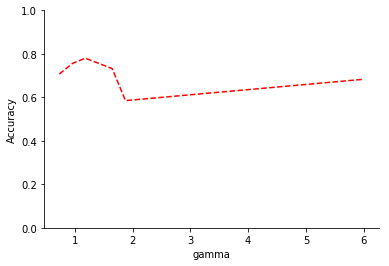

In [80]:
plt.plot(df.gamma, df.accuracy, '--', color='red')
plt.ylim([0, 1])
plt.xlabel('gamma')
plt.ylabel('Accuracy')

sns.despine()

plt.savefig('../temp/gamma_accuracy.pdf', transparent=True)

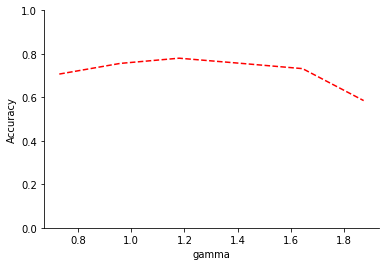

In [81]:
plt.plot(df.drop(6).gamma, df.drop(6).accuracy, '--', color='red')
plt.ylim([0, 1])
plt.xlabel('gamma')
plt.ylabel('Accuracy')

sns.despine()

plt.savefig('../temp/gamma_accuracy-all.pdf', transparent=True)